In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgboost
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LarsCV, RidgeCV, Lars
import warnings
import random

import datetime
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import catboost as cb
import scipy
from sklearn.cluster import DBSCAN
from pandas.api.types import is_numeric_dtype



warnings.filterwarnings('ignore')
np.random.seed(1)
random.seed(1)
import time
import gc

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8,4)
rcParams['font.size'] = 12

In [3]:
DEBUG = False
REF_DATE = datetime.datetime.strptime('2019-6-3', '%Y-%m-%d')

In [4]:
def skip_func(i, p=0.1, debug=DEBUG):
    if debug == True:
        return (i>0 and random.random()>p)
    else:
        return False

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id='modeling'></a>

## Modeling

Here we use [out of fold stacking ensemble](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/). The architecture is as followed:

**Layer 1**:
* 2 lightgbm
* 1 xgboost
* 1 catboost
* 1 dense neural network

**Layer 2**:
* Lasso regression
* Ridge regression


In [6]:
'''%%time

FEATS_EXCLUDED = [
    "ID","tradeMoney"]
train = pd.read_csv('train_clean4.csv',encoding = 'gbk')
test = pd.read_csv('test_clean4.csv',encoding = 'gbk')

train = train[train.tradeMoney < 100000]
train = train[train.tradeMoney > 500]

train = train[train.area < 2500]

features = [c for c in train.columns if c not in FEATS_EXCLUDED]

target = train['tradeMoney']'''

'%%time\n\nFEATS_EXCLUDED = [\n    "ID","tradeMoney"]\ntrain = pd.read_csv(\'train_clean4.csv\',encoding = \'gbk\')\ntest = pd.read_csv(\'test_clean4.csv\',encoding = \'gbk\')\n\ntrain = train[train.tradeMoney < 100000]\ntrain = train[train.tradeMoney > 500]\n\ntrain = train[train.area < 2500]\n\nfeatures = [c for c in train.columns if c not in FEATS_EXCLUDED]\n\ntarget = train[\'tradeMoney\']'

In [7]:
FEATS_EXCLUDED = ["ID","tradeMoney"]
train = pd.read_csv('train_clean.csv',encoding = 'gbk')
test = pd.read_csv('test_clean.csv',encoding = 'gbk')
features = [c for c in train.columns if c not in FEATS_EXCLUDED]
target = train['tradeMoney']

### First layer
#### Tree-based model

In [8]:
# List of model to use
if DEBUG == True:
    ITERATIONS = 1
else:
    ITERATIONS = 200000
lgb1 = lgb.LGBMRegressor(
                        objective= 'regression_l2',
                        num_leaves=111,
                        max_depth=9,
                        learning_rate=0.0035591640406098355,
                        n_estimators=ITERATIONS,
                        min_child_samples=63,
                        subsample=0.6815424617328696,
                        subsample_freq=1,
                        feature_fraction=0.5020039195436962,
                        reg_lambda=8.570580601734264,
                        random_state=2333,
                        n_jobs=4,
                        metrics='rmse',
                          device = 'gpu',
                          gpu_platform_id= 1,
                          gpu_device_id=0,
                          num_thread = 1,
                          sparse_threshold= 1)



xgb1 = xgb.XGBRegressor(learning_rate= 0.0035591640406098355,
                        booster= 'gbtree',
                        alpha = 1.0239095745311145e-08,
                        boosting= 'gbdt',
                        num_leaves= 31,
                        colsample_bytree= 0.5406862297709868,
                        subsample= 0.9594952525792275,
                        max_depth= 5,
                        reg_lambda= 3.143121436123109,
                        eta= 2.9162386740282797e-07,
                        gamma= 6.015464829655147e-07,
                        grow_policy= 'depthwise',
                       random_state=2333,
                        )

cb1 = cb.CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = 2333,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )



In [9]:
if DEBUG==True:
    N_FOLDS=2
else:
    N_FOLDS=11
layer1_models = [lgb1,xgb1,cb1 ]#, ada1]
layer1_names = ['lightgbm1','xgboost', 'catboost1']#, 'adaboost1']


In [10]:
oof_train = np.zeros(shape=(len(train),len(layer1_models)))
oof_test = np.zeros(shape=(len(test),len(layer1_models)))

# Recording results
layer1_score = []
feature_importance = []

In [11]:
for i in range(len(layer1_models)):
    feature_importance_df = pd.DataFrame()
    print('\n')
    name = layer1_names[i]
    model = layer1_models[i]
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=2333)
    print('Training %s' %name)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[features], train['tradeMoney'])):
        print('Fold no %i/%i'%(fold_+1,N_FOLDS))
        trn_data = train[features].iloc[trn_idx]
        trn_label = train['tradeMoney'].iloc[trn_idx]
        val_data = train[features].iloc[val_idx]
        val_label = train['tradeMoney'].iloc[val_idx]
        if 'ada' in name:
            model.fit(X=trn_data, y=trn_label)
        else:
            model.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=1000,
                     early_stopping_rounds=200)

        oof_train[val_idx,i] = model.predict(val_data)
        oof_test[:,i] += model.predict(test[features])/N_FOLDS
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score = r2_score(target, oof_train[:,i])
    layer1_score.append(score)
    feature_importance.append(feature_importance_df)
    print('Training CV score: %.5f' %score)



Training lightgbm1
Fold no 1/11
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1198.33	valid_1's rmse: 1468.01
[2000]	training's rmse: 1083.47	valid_1's rmse: 1382.06
[3000]	training's rmse: 1025.74	valid_1's rmse: 1357.78
[4000]	training's rmse: 980.847	valid_1's rmse: 1338.82
[5000]	training's rmse: 943.857	valid_1's rmse: 1326.49
[6000]	training's rmse: 911.964	valid_1's rmse: 1315.02
[7000]	training's rmse: 884.452	valid_1's rmse: 1306.6
[8000]	training's rmse: 859.431	valid_1's rmse: 1299.63
[9000]	training's rmse: 836.759	valid_1's rmse: 1294.52
[10000]	training's rmse: 816.115	valid_1's rmse: 1289.79
[11000]	training's rmse: 797.276	valid_1's rmse: 1285.53
[12000]	training's rmse: 779.104	valid_1's rmse: 1281.24
[13000]	training's rmse: 762.812	valid_1's rmse: 1278.41
[14000]	training's rmse: 747.605	valid_1's rmse: 1275.73
[15000]	training's rmse: 732.538	valid_1's rmse: 1272.44
[16000]	training's rmse: 718.803	valid_1's rmse: 1269.46
[

[11000]	training's rmse: 805.913	valid_1's rmse: 1141.16
[12000]	training's rmse: 787.443	valid_1's rmse: 1139.97
[13000]	training's rmse: 770.75	valid_1's rmse: 1138.5
Early stopping, best iteration is:
[12947]	training's rmse: 771.637	valid_1's rmse: 1138.38
Fold no 11/11
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1186.58	valid_1's rmse: 1682.98
[2000]	training's rmse: 1076.13	valid_1's rmse: 1540.81
[3000]	training's rmse: 1018.22	valid_1's rmse: 1498.46
[4000]	training's rmse: 973.476	valid_1's rmse: 1475.42
[5000]	training's rmse: 936.255	valid_1's rmse: 1461.14
[6000]	training's rmse: 904.533	valid_1's rmse: 1450.37
[7000]	training's rmse: 877.242	valid_1's rmse: 1441.54
[8000]	training's rmse: 852.611	valid_1's rmse: 1435.64
[9000]	training's rmse: 830.42	valid_1's rmse: 1429.38
[10000]	training's rmse: 810.11	valid_1's rmse: 1424.82
[11000]	training's rmse: 791.164	valid_1's rmse: 1421.6
[12000]	training's rmse: 773.473	valid_1's rmse

1000:	learn: 1482.9596258	test: 1482.9596258	test1: 1449.5126267	best: 1449.5126267 (1000)	total: 41.1s	remaining: 1h 7m 49s
2000:	learn: 1359.5443865	test: 1359.5443865	test1: 1363.2489602	best: 1363.2489602 (2000)	total: 1m 21s	remaining: 1h 6m 15s
3000:	learn: 1308.2470381	test: 1308.2470381	test1: 1331.3300900	best: 1331.2804554 (2999)	total: 1m 58s	remaining: 1h 3m 44s
4000:	learn: 1273.9127022	test: 1273.9127022	test1: 1314.9228174	best: 1314.9228174 (4000)	total: 2m 34s	remaining: 1h 1m 48s
5000:	learn: 1246.2442232	test: 1246.2442232	test1: 1308.2334356	best: 1307.8441537 (4919)	total: 3m 14s	remaining: 1h 1m 30s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1307.844154
bestIteration = 4919

Shrink model to first 4920 iterations.
Fold no 3/11
0:	learn: 5947.1894708	test: 5947.1894708	test1: 5831.0673272	best: 5831.0673272 (0)	total: 41.5ms	remaining: 1h 9m 12s
1000:	learn: 1479.0925946	test: 1479.0925946	test1: 1468.7788008	best: 1468.7788008 (1000)	total: 

27000:	learn: 1024.4639830	test: 1024.4639830	test1: 1191.4067587	best: 1191.3996278 (26996)	total: 17m 29s	remaining: 47m 17s
28000:	learn: 1021.1972403	test: 1021.1972403	test1: 1190.4639795	best: 1190.4505282 (27991)	total: 18m 9s	remaining: 46m 40s
29000:	learn: 1018.8561155	test: 1018.8561155	test1: 1189.6601017	best: 1189.6599354 (28999)	total: 18m 48s	remaining: 46m 3s
30000:	learn: 1015.9947486	test: 1015.9947486	test1: 1188.6348757	best: 1188.6348757 (30000)	total: 19m 27s	remaining: 45m 24s
31000:	learn: 1015.0277983	test: 1015.0277983	test1: 1188.1971375	best: 1188.1888542 (30997)	total: 20m 3s	remaining: 44m 38s
32000:	learn: 1013.4424254	test: 1013.4424254	test1: 1187.5537784	best: 1187.5537784 (32000)	total: 20m 42s	remaining: 44m 1s
33000:	learn: 1011.8554692	test: 1011.8554692	test1: 1186.8555108	best: 1186.8522705 (32991)	total: 21m 22s	remaining: 43m 22s
34000:	learn: 1009.9055297	test: 1009.9055297	test1: 1185.7408193	best: 1185.7407876 (33998)	total: 22m 1s	remainin

Fold no 7/11
0:	learn: 5932.7350900	test: 5932.7350900	test1: 5971.1124461	best: 5971.1124461 (0)	total: 37.8ms	remaining: 1h 3m 4s
1000:	learn: 1473.0472206	test: 1473.0472206	test1: 1575.3182775	best: 1575.3182775 (1000)	total: 41.6s	remaining: 1h 8m 34s
2000:	learn: 1358.4759856	test: 1358.4759856	test1: 1479.1779447	best: 1479.1779447 (2000)	total: 1m 21s	remaining: 1h 6m 25s
3000:	learn: 1312.5560355	test: 1312.5560355	test1: 1445.1848095	best: 1445.1848095 (3000)	total: 1m 59s	remaining: 1h 4m 13s
4000:	learn: 1260.8131960	test: 1260.8131960	test1: 1405.9761922	best: 1405.9761922 (4000)	total: 2m 38s	remaining: 1h 3m 19s
5000:	learn: 1218.5421290	test: 1218.5421290	test1: 1379.0988948	best: 1379.0988948 (5000)	total: 3m 17s	remaining: 1h 2m 35s
6000:	learn: 1189.5025393	test: 1189.5025393	test1: 1365.3293475	best: 1365.3293475 (6000)	total: 3m 57s	remaining: 1h 2m 3s
7000:	learn: 1168.6081535	test: 1168.6081535	test1: 1357.3304783	best: 1357.2984471 (6993)	total: 4m 38s	remaining

21000:	learn: 1030.8620695	test: 1030.8620695	test1: 1219.1516108	best: 1219.1506477 (20998)	total: 14m 2s	remaining: 52m 48s
22000:	learn: 1028.0004024	test: 1028.0004024	test1: 1218.0529029	best: 1218.0419011 (21989)	total: 14m 37s	remaining: 51m 51s
23000:	learn: 1024.4385246	test: 1024.4385246	test1: 1216.4782214	best: 1216.4741153 (22997)	total: 15m 16s	remaining: 51m 6s
24000:	learn: 1017.5112976	test: 1017.5112976	test1: 1214.5373724	best: 1214.5301845 (23985)	total: 15m 55s	remaining: 50m 25s
25000:	learn: 1010.7243571	test: 1010.7243571	test1: 1212.7379003	best: 1212.7379003 (25000)	total: 16m 31s	remaining: 49m 35s
26000:	learn: 1004.6165587	test: 1004.6165587	test1: 1210.4728138	best: 1210.4728138 (26000)	total: 17m 11s	remaining: 48m 55s
27000:	learn: 998.4966638	test: 998.4966638	test1: 1207.4595101	best: 1207.4587972 (26996)	total: 17m 51s	remaining: 48m 18s
28000:	learn: 993.2855550	test: 993.2855550	test1: 1205.3954711	best: 1205.3837984 (27987)	total: 18m 32s	remaining

Exchange two models

In [12]:
oof_preds=np.loadtxt('lgb_oof_preds-0.90448.csv',delimiter=',')
sub_preds=np.loadtxt('lgb_sub_preds-0.90448.csv',delimiter=',')


score = r2_score(target, oof_preds)
print('Training CV score for LGB: %.5f' %score)
layer1_names.append('LGB')
layer1_score.append(score)

oof_preds = oof_preds[:, np.newaxis]
sub_preds = sub_preds[:, np.newaxis]
oof_train = np.hstack((oof_train, oof_preds))
oof_test = np.hstack((oof_test, sub_preds))

Training CV score for LGB: 0.90448


In [13]:
oof_preds=np.loadtxt('xgb_oof_preds-0.886.csv',delimiter=',')
sub_preds=np.loadtxt('xgb_sub_preds-0.886.csv',delimiter=',')

score = r2_score(target, oof_preds)
print('Training CV score for XGB1: %.5f' %score)
layer1_names.append('XGB1')
layer1_score.append(score)

oof_preds = oof_preds[:, np.newaxis]
sub_preds = sub_preds[:, np.newaxis]
oof_train = np.hstack((oof_train, oof_preds))
oof_test = np.hstack((oof_test, sub_preds))

Training CV score for XGB1: 0.88681


In [14]:
oof_preds=np.loadtxt('xgb_oof_preds-0.89566.csv',delimiter=',')
sub_preds=np.loadtxt('xgb_sub_preds-0.89566.csv',delimiter=',')

score = r2_score(target, oof_preds)
print('Training CV score for XGB2: %.5f' %score)
layer1_names.append('XGB2')
layer1_score.append(score)

oof_preds = oof_preds[:, np.newaxis]
sub_preds = sub_preds[:, np.newaxis]
oof_train = np.hstack((oof_train, oof_preds))
oof_test = np.hstack((oof_test, sub_preds))

Training CV score for XGB2: 0.89566


In [15]:
layer1_names

['lightgbm1', 'xgboost', 'catboost1', 'LGB', 'XGB1', 'XGB2']

#### Layer 1 summary

In [16]:
# Print first layer result
layer1 = pd.DataFrame()
layer1['models'] = layer1_names
layer1['CV_score'] = layer1_score
layer1

,models,CV_score
0,lightgbm1,0.894896
1,xgboost,0.873454
2,catboost1,0.879381
3,LGB,0.904476
4,XGB1,0.886811
5,XGB2,0.895662


Text(0.5,1,'Pair-wise correlation')

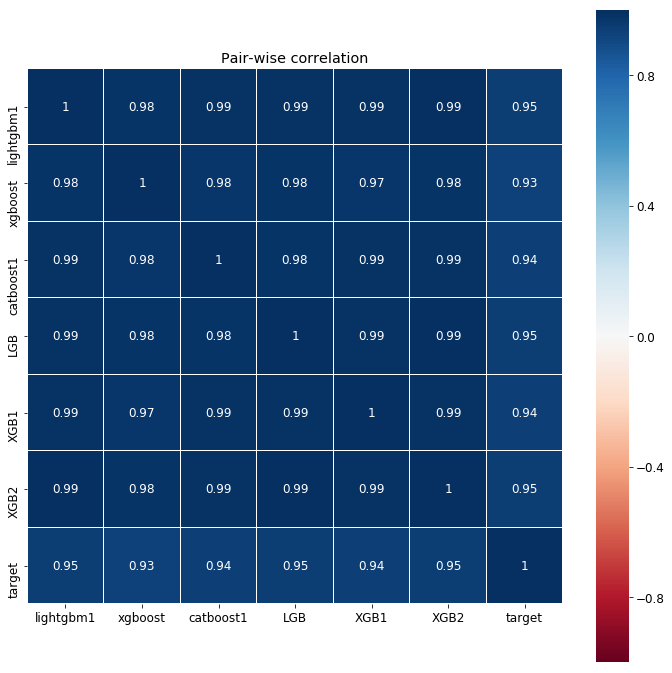

In [17]:
layer1_corr = pd.DataFrame()
for i in range(len(layer1_names)):
    layer1_corr[layer1_names[i]] = oof_train[:,i]
layer1_corr['target'] = target
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
sns.heatmap(layer1_corr.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

### Second layer

In [18]:
# Setup the model
ridge = Ridge(alpha=0.5)#, fit_intercept=False)
lasso = Lasso(alpha=0.5)
lars = Lars(fit_intercept=False, positive=True)
layer2_models = [lars]#[ridge]# lasso]
layer2_names = ['Lars']#['ridge'] #, 'lasso']
#params_grid = {'alpha':[0.05,0.1,0.4,1.0]}

# Setup to record result
train_pred = np.zeros(len(train))
test_pred = np.zeros(len(test))

layer2 = pd.DataFrame()
layer2['models'] = layer2_names
layer2_score = []

In [19]:
# For regression

for i in range(len(layer2_models)):
    print('\n')
    name = layer2_names[i]
    model = layer2_models[i]
    print('Training %s' %name)
    #model, score = do_regressor((oof_train, target), model=model, parameters=params_grid)
    model.fit(oof_train, target)
    score = r2_score(target, model.predict(oof_train))
    train_pred += model.predict(oof_train)/len(layer2_models)
    test_pred += model.predict(oof_test)/len(layer2_models)
    layer2_score.append(score)
    print('Training score: %.5f' % score)

#layer2['CV score'] = layer2_score
#layer2

layer2_coef = pd.DataFrame()
layer2_coef['Name'] = layer1_names
layer2_coef['Coefficient'] = model.coef_
#layer2_coef['Coefficient'] = coef
layer2_coef



Training Lars
Training score: 0.90532


,Name,Coefficient
0,lightgbm1,0.054215
1,xgboost,0.096418
2,catboost1,0.000000
3,LGB,0.768663
4,XGB1,0.021787
5,XGB2,0.062195


In [29]:
'''
# Taking average
train_pred = np.mean(oof_train, axis=1)
test_pred = np.mean(oof_test, axis=1)
print('Training score: %.5f' %mean_squared_error(train_pred, target)**0.5)
'''

"\n# Taking average\ntrain_pred = np.mean(oof_train, axis=1)\ntest_pred = np.mean(oof_test, axis=1)\nprint('Training score: %.5f' %mean_squared_error(train_pred, target)**0.5)\n"

In [30]:
#np.sum(model.coef_)

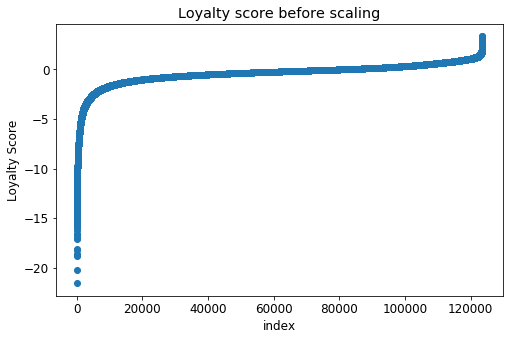

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(test_pred)), np.sort(test_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score before scaling')
plt.show()

In [32]:
# Refit to the target
train_scaler = StandardScaler()
#train_scaler.fit(target.values.reshape(-1,1))
#test_pred = train_scaler.inverse_transform(test_pred.reshape(-1,1))

### Submission

In [33]:
#sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission["target"] = test_pred
sample_submission.to_csv("model-stacking-ensemble-low_features-StratifiedKFold11.csv ", index=False)

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(range(sub_df.shape[0]), np.sort(sub_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score after scaling')
plt.show()

NameError: name 'sub_df' is not defined

<Figure size 576x360 with 0 Axes>